# Create a datamodule for multi-styles of road images from OSMnx

## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable

from pprint import pprint
import joblib


In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers

import ray
# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [ ]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
# print(sys.path)



In [ ]:
# from src.data.datasets.maptiles import Maptiles, MapStyles
# from src.data.datamodules.mnist_datamodule import MNISTDataModule
# from src.data.datamodules.maptiles_datamodule import MaptilesDataModule
from src.data.datamodules.multisource_maptiles_datamodule import MultiMaptilesDataModule


# from src.models.plmodules.three_fcs import ThreeFCs
# from src.models.plmodules.vanilla_vae import VanillaVAE
# from src.models.plmodules.beta_vae import BetaVAE
from src.models.plmodules.bilatent_vae import BiVAE

from src.visualize.utils import show_timgs, show_npimgs
from src.utils.misc import info, get_next_version_path, n_iter_per_epoch


## Globals


In [ ]:
ALL_CITIES = sorted(
    ['la', 'charlotte', 'vegas', 'boston', 'paris', \
     'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
     'berlin', 'montreal', 'rome']#'london'
) 

## Show sample images of OSMnx


In [ ]:
out_dir_root = Path("/data/hayley-old/Tenanbaum2000/nbs/Geospatial/temp/images")
zoom = '14'
city = 'amsterdam'

def show_samples(out_dir_root:Path,
                city:str, 
                n_show_per_style:int =3,
                zoom: str='14',
               ):
    city_dir = out_dir_root/city
    if not city_dir.exists():
        raise ValueError(f'{city_dir} does not exist')

    edge_color = 'cyan'
    bldg_color = 'silver'
    lw_factor = 0.5
    bgcolors = ['k', 'r', 'g', 'b', 'y']
    n_show_per_style = 3
    for bgcolor in bgcolors:
        r_style = f'OSMnxR-{bgcolor}-{edge_color}-{lw_factor}'
        rb_style = f'OSMnxRB-{bgcolor}-{edge_color}-{bldg_color}-{lw_factor}'

        r_dir = city_dir/r_style/zoom
        rb_dir = city_dir/rb_style/zoom

        r_it = r_dir.iterdir()
        rb_it = rb_dir.iterdir()

        # Loop inside the image dirs
        print("="*10)
        print(r_style, rb_style)

        i = 0
        f, axes = plt.subplots(n_show_per_style, 2, 
                             figsize=(16, 7*n_show_per_style))
        f.suptitle(f'{city}: {bgcolor}')
        while i < n_show_per_style:
            r_fn = next(r_it)
            rb_fn  = next(rb_it)

            r_img = plt.imread(r_fn)
            rb_img = plt.imread(rb_fn)

            axes[i][0].imshow(r_img)
            axes[i][0].set_title(f'{city}-R')
            axes[i][1].imshow(rb_img)
            axes[i][1].set_title(f'{city}-R+B')
            i += 1            
            
        for ax in axes.flatten():
            ax.set_axis_off()
        f.tight_layout()
        f.show()



In [ ]:
out_dir_root = Path("/data/hayley-old/Tenanbaum2000/nbs/Geospatial/temp/images")
zoom = '14'
all_cities = sorted(
    ['la', 'charlotte', 'vegas', 'boston', 'paris', \
     'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
     'berlin', 'montreal', 'rome']#'london'
) 
for city in all_cities:
    show_samples(out_dir_root, city)
    break
    
         
    
                        
    
    

# Create png files by showing OSMnxR and OSMnxRB images from all cities, of all generated styles
May 9, 2021
- [ ] Make the function `show_samples_for_cities` into a python script under `/data/hayly-old/TileGenerator/script`


In [ ]:
def random_items(iterator, items_wanted=1):
    selected_items = [None] * items_wanted

    for item_index, item in enumerate(iterator):
        for selected_item_index in xrange(items_wanted):
            if not random.randint(0, item_index):
                selected_items[selected_item_index] = (item_index, item)

    return selected_items

In [ ]:
out_dir_root = Path("/data/hayley-old/Tenanbaum2000/nbs/Geospatial/temp/images")
zoom = '14'
city = 'amsterdam'

def show_samples_for_cities(out_dir_root:Path,
                cities: List[str], 
                n_show_per_style: int =3,
                zoom: str='14',
               ):
    
    edge_color = 'cyan'
    bldg_color = 'silver'
    lw_factor = 0.5
    bgcolors = ['k', 'r', 'g', 'b', 'y']
    
    n_cities = len(cities)
    n_styles = len(bgcolors)
    n_show_per_style = 3
    
    nrows = n_styles
    ncols = n_cities * n_show_per_style
    r_fig, r_axes = plt.subplots(nrows, 
                                 ncols,
                                 figsize=(7*ncols, 7*nrows)
                                )
    rb_fig, rb_axes = plt.subplots(nrows, 
                             ncols,
                             figsize=(7*ncols, 7*nrows)
                            )
#     debug
#     print('nrows, ncols: ', nrows, ncols)
#     breakpoint()
    
    for i_city, city in enumerate(cities):
        city_dir = out_dir_root/city
        if not city_dir.exists():
            raise ValueError(f'{city_dir} does not exist')
            
        for i_style, bgcolor in enumerate(bgcolors):
            r_style = f'OSMnxR-{bgcolor}-{edge_color}-{lw_factor}'
            rb_style = f'OSMnxRB-{bgcolor}-{edge_color}-{bldg_color}-{lw_factor}'

            r_dir = city_dir/r_style/zoom
            rb_dir = city_dir/rb_style/zoom

            r_it = r_dir.iterdir()
            rb_it = rb_dir.iterdir()
            
            # Loop inside the image dirs
            print("="*10)
            print(r_style, rb_style)

            i_loc = 0
            while i_loc < n_show_per_style:
                r_fn = next(r_it)
                rb_fn  = next(rb_it)

                r_img = plt.imread(r_fn)
                rb_img = plt.imread(rb_fn)

                i_col = i_city*n_show_per_style+i_loc
                # Draw on road figure
                r_axes[i_style][i_col].imshow(r_img)
                r_axes[i_style][i_col].set_title(f'{city}[{i_loc}]')

                # Draw on road+bldg figure
                rb_axes[i_style][i_col].imshow(rb_img)
                rb_axes[i_style][i_col].set_title(f'{city}[{i_loc}]')


#                 # debug
#                 print('city[i_city], i_loc: ', city, i_city, i_loc)
#                 print('irow, icol: ',i_style, i_col)
#                 breakpoint()
                
                i_loc += 1  

    for ax in r_axes.flatten():
        ax.set_axis_off()
    for ax in rb_axes.flatten():
        ax.set_axis_off()

    r_fig.tight_layout()
    rb_fig.tight_layout()

    r_fig.savefig('./roads.png')
    rb_fig.savefig('./rbs.png')
    
    return r_fig, rb_fig



In [ ]:
out_dir_root = Path("/data/hayley-old/Tenanbaum2000/nbs/Geospatial/temp/images")
zoom = '14'
city = 'amsterdam'

def show_random_samples_for_cities(
    out_dir_root:Path,
    cities: List[str], 
    n_show_per_style: int =3,
    zoom: str='14',
):
    
    edge_color = 'cyan'
    bldg_color = 'silver'
    lw_factor = 0.5
    bgcolors = ['k', 'r', 'g', 'b', 'y']
    
    n_cities = len(cities)
    n_styles = len(bgcolors)
    n_show_per_style = 3
    
    nrows = n_styles
    ncols = n_cities * n_show_per_style
    r_fig, r_axes = plt.subplots(nrows, 
                                 ncols,
                                 figsize=(7*ncols, 7*nrows)
                                )
    rb_fig, rb_axes = plt.subplots(nrows, 
                             ncols,
                             figsize=(7*ncols, 7*nrows)
                            )
#     debug
#     print('nrows, ncols: ', nrows, ncols)
#     breakpoint()
    
    for i_city, city in enumerate(cities):
        city_dir = out_dir_root/city
        if not city_dir.exists():
            raise ValueError(f'{city_dir} does not exist')
            
        for i_style, bgcolor in enumerate(bgcolors):
            r_style = f'OSMnxR-{bgcolor}-{edge_color}-{lw_factor}'
            rb_style = f'OSMnxRB-{bgcolor}-{edge_color}-{bldg_color}-{lw_factor}'

            r_dir = city_dir/r_style/zoom
            rb_dir = city_dir/rb_style/zoom

            r_it = r_dir.iterdir()
            rb_it = rb_dir.iterdir()
            
            selected_r_fns = random_items(r_it, items_wanted=n_show_per_style)
            breakpoint()


            # Loop inside the image dirs
            print("="*10)
            print(r_style, rb_style)

            for i_loc, r_fn in selected_fns:
            while i_loc < n_show_per_style:
                rb_fn  = next(rb_it)

                r_img = plt.imread(r_fn)
                rb_img = plt.imread(rb_fn)

                i_col = i_city*n_show_per_style+i_loc
                # Draw on road figure
                r_axes[i_style][i_col].imshow(r_img)
                r_axes[i_style][i_col].set_title(f'{city}[{i_loc}]')

                # Draw on road+bldg figure
                rb_axes[i_style][i_col].imshow(rb_img)
                rb_axes[i_style][i_col].set_title(f'{city}[{i_loc}]')


#                 # debug
#                 print('city[i_city], i_loc: ', city, i_city, i_loc)
#                 print('irow, icol: ',i_style, i_col)
#                 breakpoint()
                
                i_loc += 1  

    for ax in r_axes.flatten():
        ax.set_axis_off()
    for ax in rb_axes.flatten():
        ax.set_axis_off()

    r_fig.tight_layout()
    rb_fig.tight_layout()

    r_fig.savefig('./roads.png')
    rb_fig.savefig('./rbs.png')
    
    return r_fig, rb_fig



In [ ]:
out_dir_root = Path("/data/hayley-old/Tenanbaum2000/nbs/Geospatial/temp/images")
zoom = '14'
all_cities = sorted(
    ['la', 'charlotte', 'vegas', 'boston', 'paris', \
     'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
     'berlin', 'montreal', 'rome']#'london'
) 
r_fig, rb_figs = show_samples_for_cities(
    out_dir_root,
    all_cities)

---
May 10, 2021

# Inspect the hand-designed road-network indicators/features


In [ ]:
data_root = Path('/data/hayley-old/osmnx_data/')
img_dir = data_root/'images'
record_dir = data_root/'records'

In [ ]:
# load each city's road network stats
def load_records(
    record_dir: Path,
    city: str,
    style: str,
    zoom: Union[int, str],
    version: int = 0,
)-> List[Dict]:
    city = city.lower()
    fn = record_dir / f'{city}-{style}-{zoom}-ver{version}.pkl'
    if not fn.exists():
        raise ValueError(f"{fn} doesn't exist. Check spelling, lower/uppercase of the city, stlye names, and also version")
    return joblib.load(fn)

In [ ]:
def test_load_records():
    style = 'StamenTonerLines'
    zoom = 14
    city = 'seoul'
    records = load_records(record_dir, city, style, zoom)
    df = pd.DataFrame(records)
    display(df.head())

In [ ]:
test_load_records()

In [ ]:
# Collect records from all cities into a single list
cities = [c for c in ALL_CITIES if not c.startswith('shang')]
style = 'StamenTonerLines'
zoom = 14
all_records = []
for city in cities:
    records = load_records(record_dir, city, style, zoom)
    all_records.extend(records)
    
    

In [ ]:
len(all_records)

In [ ]:
df = pd.DataFrame(all_records)

In [ ]:
df.head()
cols = df.columns
int_count_cols = [c for c in df.columns if c.startswith('int_') and c.endswith('count')]
int_prop_cols = [c for c in df.columns if c.startswith('int_') and c.endswith('prop')]
pprint(cols)

In [ ]:
# remove rows whose `retrieved_road` is false
has_road = df.retrieved_road
inds = df.index[has_road]
df = df.iloc[inds]
display(df)

## [SN] `circuity_avg` feature
- why inf?


In [ ]:
circuity = df.circuity_avg

In [ ]:
circuity.isinf().sum()

In [ ]:
# let's load a graph
x,y,z = 

In [ ]:
c_isinf = np.isinf(circuity)

In [ ]:
c_isinf.sum()

In [ ]:
inds_inf_cc = df.index[c_isinf]
df[

## Basic stats of the road network feats across all cities

In [ ]:
# FEATURES
feat_names = [
    'k_avg',
    'streets_per_node_avg', #avged 'n' in Nway
    'street_length_total',
    'street_length_avg', # how is this computed?
    'node_density_km',
    'intersection_density_km',
    'edge_density_km',
    'street_density_km',
    'int_1_prop',
    'int_2_prop',
    'int_3_prop',
    'int_4_prop'
]


In [ ]:
df_feats = df[['city'] + feat_names]


In [ ]:
df_feats.head()


In [ ]:
for feat in feat_names:
    
    df_feats.hist(column=feat, by='city', figsize=(21,28));
    f = plt.gcf()
    f.suptitle(feat, fontsize=50)
    f.savefig(f'./{feat}.png')


In [ ]:
df_int = df[['city'] + int_prop_cols]


In [ ]:
display(df_int)

In [ ]:
for colname in int_prop_cols:
    na_count = df_int[colname].isna().sum()
    na_prop = na_count / len(df)
    if na_prop > 0.5:
        print(colname,na_prop) 

In [ ]:
df_int.city.unique()

In [ ]:
int_mode = df_int[int_prop_cols].idxmax(axis='columns', skipna=True)
# filter out the 

In [ ]:
int_mode = int_mode.apply(lambda colname: int(colname.split('_')[1]))

In [ ]:
df_int['int_mode'] = int_mode
display(df_int)

In [ ]:
int_mode.unique()

In [ ]:
df_int.hist(column='int_mode', by='city', sharex=True,
           figsize=(21,28))

In [ ]:
df_summary = df_feats.describe()
nan_cols = df_summary.columns[df_summary.isna().any()].tolist()

In [ ]:
print(nan_cols)

In [ ]:
col2drop = ['x','y','z','lat_deg', 'lng_deg'] + int_count_cols + nan_cols

In [ ]:
df_summary.drop(columns=col2drop, 
                inplace=True,
               errors='ignore')

In [ ]:
df_summary.columns

In [ ]:
# df_summary.isna().any()

In [ ]:
print(int_count_cols)

In [ ]:
df_summary.hist()

## You gotta come back, Hayley
- May 17, 2021 7.40pm

Goal: 
- [ ] Make a datamodule class for OSMnxRoad with flexible defintiion of the domain label `d`

## Test construction of MaptileDataset with OSMnxRoad data
- May 18, 2021

In [ ]:
from src.data.datasets.maptiles_bifactor import MaptilesDataset

In [ ]:
data_root = Path("/data/hayley-old/osmnx_data/images")

# Style parameters
edge_color = 'cyan'
lw_factor = 0.5
bgcolors = ['k', 'r', 'g', 'b', 'y']
    
cities = ['paris'] #all_cities # ['berlin', 'rome', 'la', 'amsterdam', 'seoul'] #['paris']
styles =[f'OSMnxR-{bgcolor}-{edge_color}-{lw_factor}' for bgcolor in bgcolors]#['StamenTonerBackground','OSMDefault', 'CartoVoyagerNoLabels']#'StamenWatercolor']#, 'StamenTonerLines']
zooms = ['14']
in_shape = (3, 64, 64)
batch_size = 32
print('cities: ', cities)
print('styes: ', styles)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(in_shape[-2:]),
])

content_label_transform = transforms.Lambda(
    lambda lnglat_list: '-'.join(lnglat_list)
)

style2idx = {s:i for i,s in enumerate(styles)}
style_label_transform = transforms.Lambda(
    lambda style_label: style2idx[style_label]
)

In [ ]:
fns = MaptilesDataset.collect_fns(
    data_root,
    cities,
    styles,
    zoom,
    verbose=True
)

In [166]:
dset = MaptilesDataset(
    df_fns=fns,
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
    transform=transform,
    content_label_transform=content_label_transform,
    style_label_transform=style_label_transform,
    verbose=True
                
)

Unique styles:  ['OSMnxR-k-cyan-0.5' 'OSMnxR-r-cyan-0.5' 'OSMnxR-g-cyan-0.5'
 'OSMnxR-b-cyan-0.5' 'OSMnxR-y-cyan-0.5']


In [170]:
channel_mean, channel_std = MaptilesDataset.get_channelwise_mean_std(
    dset,
    n_channels=3
)
print(channel_mean, channel_std)


[0.27793621 0.40359681 0.36362424] [0.40444567 0.39446816 0.46144915]


## Define a new datamodule class for OSMnxRoads data

In [189]:
from src.data.datamodules.multisource_osmnxr_datamodule import MultiOSMnxRDataModule

## TLDR: This is how you initiate a datamodule for OSMRoad data

### Start experiment 
Given a maptile, predict its style as one of OSM, CartoVoyager

In [ ]:
# # Instantiate MNIST Datamodule
# in_shape = (1,32,32)
# batch_size = 32
# dm = MNISTDataModule(data_root=ROOT/'data', 
#                        in_shape=in_shape,
#                       batch_size=batch_size)
# dm.setup('fit')
# print("DM: ", dm.name)

In [174]:
# Instantiate Multisource Maptiles DataModule
data_root = Path("/data/hayley-old/osmnx_data/images")

# Collect all images from these cities
all_cities = sorted(
    ['la', 'charlotte', 'vegas', 'boston', 'paris', \
     'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
     'berlin', 'montreal', 'rome']#'london'
) 

# Style parameters
edge_color = 'cyan'
lw_factor = 0.5
bgcolors = ['k', 'r', 'g', 'b', 'y']
    
cities = ['paris'] #all_cities # ['berlin', 'rome', 'la', 'amsterdam', 'seoul'] #['paris']
styles =[f'OSMnxR-{bgcolor}-{edge_color}-{lw_factor}' for bgcolor in bgcolors]#['StamenTonerBackground','OSMDefault', 'CartoVoyagerNoLabels']#'StamenWatercolor']#, 'StamenTonerLines']
zooms = ['14']
in_shape = (3, 64, 64)
batch_size = 32
print('cities: ', cities)
print('styes: ', styles)

dm = MultiMaptilesDataModule(
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
    in_shape=in_shape,
    batch_size=batch_size,
)
dm.setup('fit')

cities:  ['paris']
styes:  ['OSMnxR-k-cyan-0.5', 'OSMnxR-r-cyan-0.5', 'OSMnxR-g-cyan-0.5', 'OSMnxR-b-cyan-0.5', 'OSMnxR-y-cyan-0.5']
Unique styles:  ['OSMnxR-k-cyan-0.5' 'OSMnxR-r-cyan-0.5' 'OSMnxR-g-cyan-0.5'
 'OSMnxR-b-cyan-0.5' 'OSMnxR-y-cyan-0.5']
*** Set the datamodule's df_fns attribute -- Save it for quicker DM init for later runs
Unique styles:  ['OSMnxR-b-cyan-0.5' 'OSMnxR-g-cyan-0.5' 'OSMnxR-k-cyan-0.5'
 'OSMnxR-r-cyan-0.5' 'OSMnxR-y-cyan-0.5']
Unique styles:  ['OSMnxR-r-cyan-0.5' 'OSMnxR-k-cyan-0.5' 'OSMnxR-b-cyan-0.5'
 'OSMnxR-g-cyan-0.5' 'OSMnxR-y-cyan-0.5']
n_train, n_val:  214 91
train channelwise_mean,std:  [0.26822889 0.40888084 0.35738282] [0.39821733 0.39205902 0.45984326]


In [192]:
# Alternatively, use 
# Instantiate Multisource Maptiles DataModule
data_root = Path("/data/hayley-old/osmnx_data/images")

# Style parameters
edge_color = 'cyan'
lw_factor = 0.5
bgcolors = ['k', 'r', 'g', 'b', 'y']
    
cities = ['paris']#, 'berlin'] #all_cities # ['berlin', 'rome', 'la', 'amsterdam', 'seoul'] #['paris']
zooms = ['14']
in_shape = (3, 64, 64)
batch_size = 32
print('cities: ', cities)
print('styes: ', styles)

dm = MultiOSMnxRDataModule(
    data_root=data_root,
    cities=cities,
    bgcolors=bgcolors,
    zooms=zooms,
    in_shape=in_shape,
    batch_size=batch_size,
)
dm.setup('fit')
print(dm.name)

cities:  ['paris']
styes:  ['OSMnxR-k-cyan-0.5', 'OSMnxR-r-cyan-0.5', 'OSMnxR-g-cyan-0.5', 'OSMnxR-b-cyan-0.5', 'OSMnxR-y-cyan-0.5']
Unique styles:  ['OSMnxR-k-cyan-0.5' 'OSMnxR-r-cyan-0.5' 'OSMnxR-g-cyan-0.5'
 'OSMnxR-b-cyan-0.5' 'OSMnxR-y-cyan-0.5']
*** Set the datamodule's df_fns attribute -- Save it for quicker DM init for later runs
Unique styles:  ['OSMnxR-b-cyan-0.5' 'OSMnxR-g-cyan-0.5' 'OSMnxR-k-cyan-0.5'
 'OSMnxR-y-cyan-0.5' 'OSMnxR-r-cyan-0.5']
Unique styles:  ['OSMnxR-r-cyan-0.5' 'OSMnxR-k-cyan-0.5' 'OSMnxR-g-cyan-0.5'
 'OSMnxR-b-cyan-0.5' 'OSMnxR-y-cyan-0.5']
n_train, n_val:  214 91
train channelwise_mean,std:  [0.26843299 0.3974244  0.35847767] [0.40021845 0.39701566 0.45961908]
Maptiles_paris_OSMnxR-b-cyan-0.5-OSMnxR-g-cyan-0.5-OSMnxR-k-cyan-0.5-OSMnxR-r-cyan-0.5-OSMnxR-y-cyan-0.5_14


Show a batch of images in train_ds

train size:  214
shape:  torch.Size([32, 3, 64, 64])
dtype:  torch.float32
min, max:  -1.0133343 1.7732517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

['8295-5637', '8296-5637', '8299-5639', '8301-5639', '8296-5637', '8294-5637', '8301-5638', '8293-5634', '8296-5638', '8299-5635', '8295-5635', '8301-5639', '8293-5634', '8297-5638', '8297-5639', '8300-5633', '8296-5639', '8299-5636', '8297-5635', '8298-5633', '8294-5638', '8296-5639', '8300-5634', '8293-5633', '8295-5633', '8296-5638', '8297-5634', '8295-5634', '8293-5639', '8294-5635', '8301-5636', '8293-5637']
tensor([3, 3, 4, 1, 1, 4, 0, 3, 3, 3, 3, 2, 0, 2, 4, 4, 0, 4, 3, 0, 4, 3, 0, 0,
        2, 2, 1, 4, 3, 2, 3, 1])


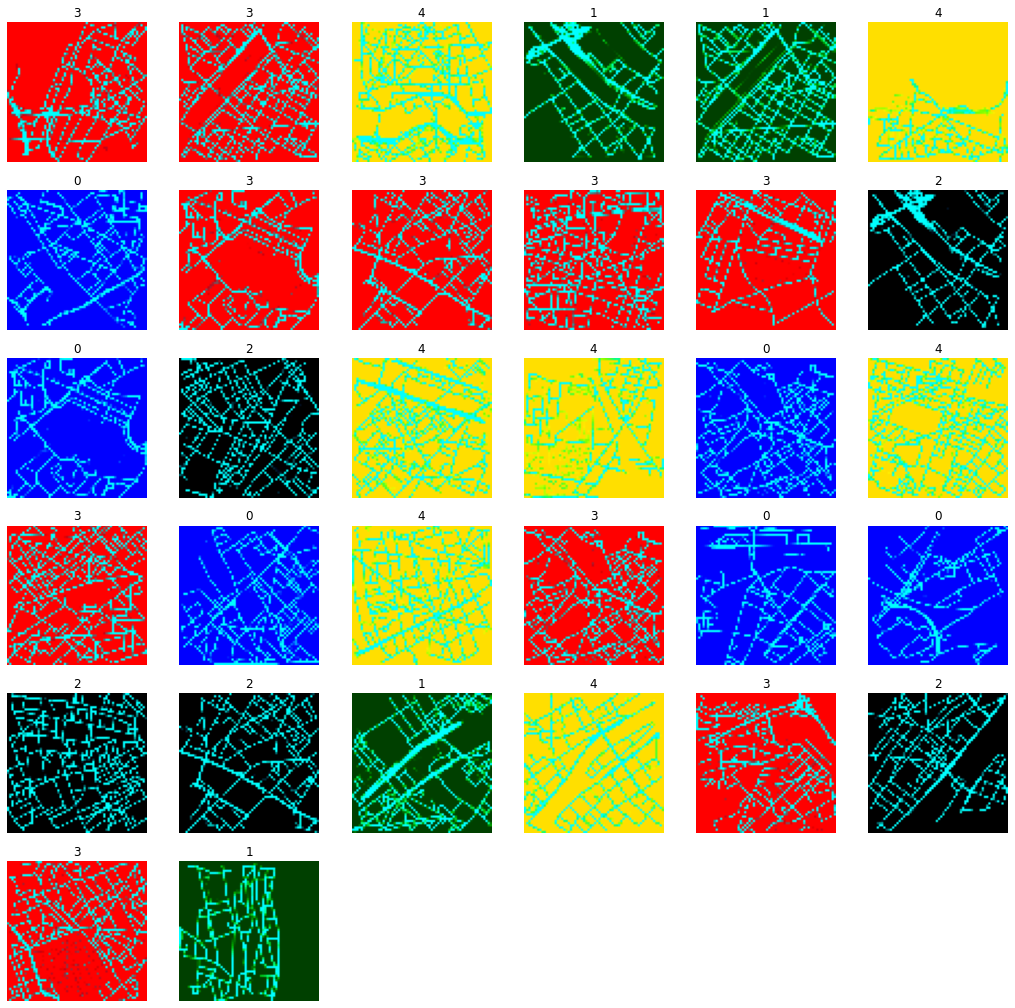

In [187]:
print('train size: ', len(dm.train_ds))
dl = dm.train_dataloader()
batch = next(iter(dl))
x, label_c, label_s = dm.unpack(batch)

info(x)
show_timgs(x, titles=label_s.tolist(), cmap='gray' if in_shape[0]==1 else None)
print(label_c)
print(label_s)